# Project Assignment 2 : Financial Risk Assessment

# 0. Introduction

This project develops a decision tree model to classify financial risk levels (Low/Medium/High). The implementation consists of two phases:

**ID3 Decision Tree Construction**  
Manual data preprocessing (handling missing values, categorical encoding)
Train/test/validation split (70%/15%/15%)
Model training with performance evaluation (accuracy, precision, recall, F1)
Rule extraction and error analysis

**Pruning Optimization**
Post-pruning to reduce overfitting
Validation-based branch removal strategy
Performance comparison of original vs pruned trees




# 1. Implementing Decision Tree

## 1.1 Data Preprocessing

In this part of the project, we prepare the dataset (financial_risk_assessment.csv) for modeling :

**Handling Missing Values** Numerical columns filled with median (robust to outliers) while categorical columns filled with mode (most frequent value).

**Encoding Categorical Features**  We convert text categories (e.g., Gender: Male/Female) to numerical labels (0/1) using ordinal encoding. This stores mappings in encoders for interpretability (e.g., {'Male': 0, 'Female': 1}).

**Target Variable Transformation** Maps Risk Rating labels to numerical values: {'Low': 0, 'Medium': 1, 'High': 2}

**Why This Matters:** This process ensures compatibility with machine learning algorithms and preserves data integrity by avoiding biased imputation.

### Install Required Libraries  
Before running the notebook, You can install all necessary libraries by running the following command by deleting "#":


In [1]:
# pip install numpy pandas opencv-python scikit-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')
%matplotlib inline
df = pd.read_csv("financial_risk_assessment.csv")

def accuracy(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

def precision(y_true, y_pred, labels):
    precisions = []
    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    return np.mean(precisions)

def recall(y_true, y_pred, labels):
    recalls = []
    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fn = np.sum((y_pred != label) & (y_true == label))
        recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    return np.mean(recalls)

def f1_score_macro(y_true, y_pred, labels):
    p = precision(y_true, y_pred, labels)
    r = recall(y_true, y_pred, labels)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

encoders = {}
for col in df.columns:
    if df[col].dtype == 'object' and col != 'Risk Rating':
        uniq = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(uniq)}
        df[col] = df[col].map(mapping)
        encoders[col] = mapping

df['Risk Rating'] = df['Risk Rating'].map({'Low': 0, 'Medium': 1, 'High': 2})

## 1.2 Data Visualization 

The visualizationcode serves two primary purposes in the exploratory data analysis phase:

**Class Distribution Analysis** 
The countplot reveals the frequency distribution of risk categories (Low, Medium, High) in the dataset. This visualization helps identify potential class imbalance issues that could bias the decision tree model, ensuring we address any disproportionate representation before training.

**Feature Correlation Examination**  The heatmap graphically represents pairwise correlations between numerical features, allowing us to detect strongly correlated variables that might:
Introduce multicollinearity problems
Guide feature selection for the ID3 algorithm
Highlight redundant attributes for potential pruning

These visualizations provide critical insights into dataset characteristics that directly inform our preprocessing strategy and model development approach.

In the end we seperated datas into train test and validation.

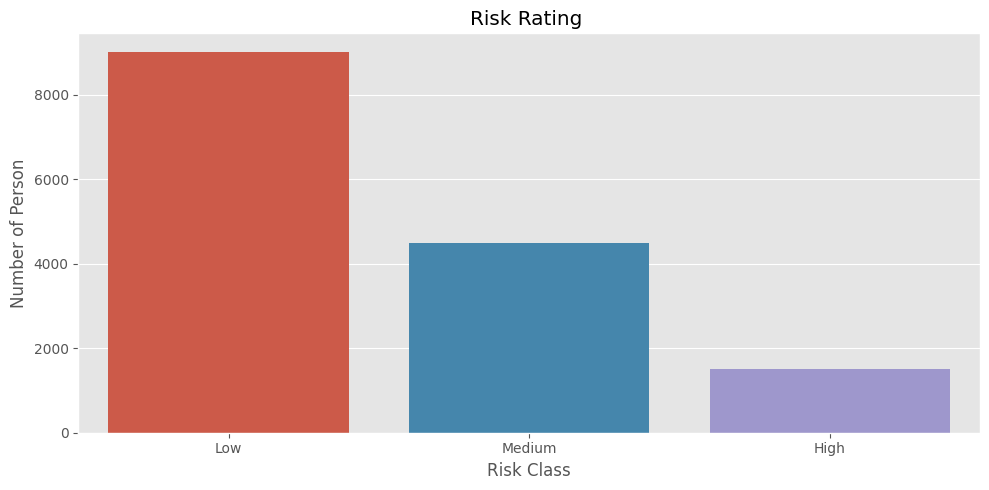

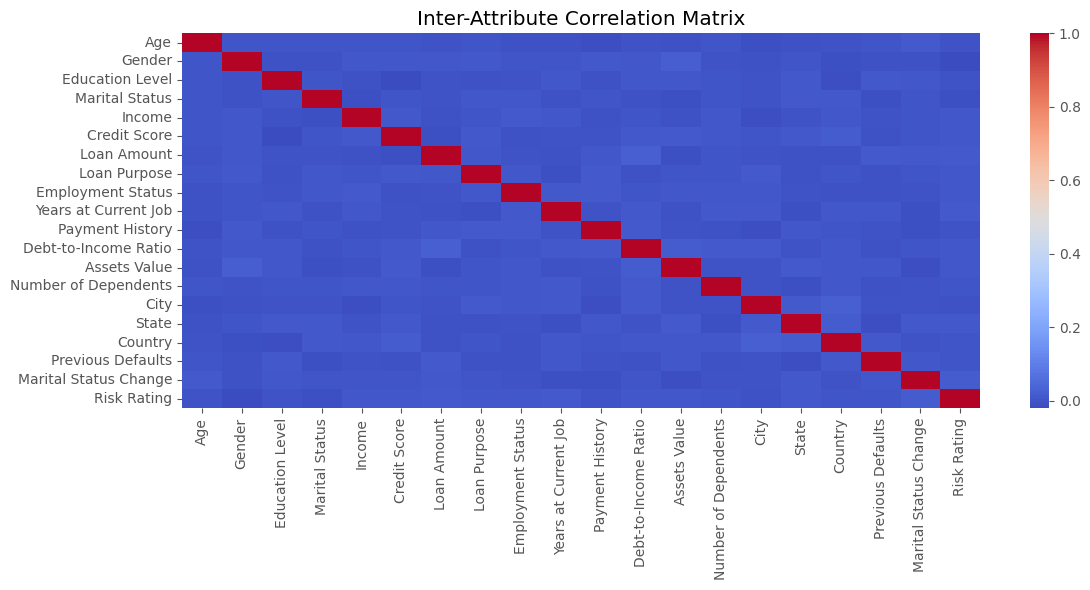

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Risk Rating')
plt.title("Risk Rating ")
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.xlabel("Risk Class")
plt.ylabel("Number of Person")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Inter-Attribute Correlation Matrix")
plt.tight_layout()
plt.show()

X = df.drop('Risk Rating', axis=1).values
y = df['Risk Rating'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 1.3 ID3 Algorithm

This code implements the ID3 decision tree algorithm for classification tasks, specifically designed for our financial risk assessment problem. The implementation consists of two main components:

**DecisionNode Class** 
The building block of our tree structure that can represent either:
Internal nodes containing decision rules (feature + threshold)
Leaf nodes storing class predictions (value)
The is_leaf_node() method helps distinguish between these cases during tree traversal.

**ID3 Class (Core Algorithm)** 
The main classifier implementing the ID3 decision tree with these key methods:
Tree Construction, Information Theory Components, Prediction Logic

This implementation provides a transparent, from-scratch version of decision trees that will serve as our baseline before pruning optimizations. The modular design allows easy extension with additional splitting criteria or pruning methods.

In [7]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class ID3:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or X.shape[1] == 0 or len(y) < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth):
            most_common = Counter(y).most_common(1)[0][0]
            return DecisionNode(value=most_common)

        best_gain, best_feat, best_thresh = -1, None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature], threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feature
                    best_thresh = threshold

        if best_gain == 0:
            return DecisionNode(value=Counter(y).most_common(1)[0][0])

        left_idx = X[:, best_feat] <= best_thresh
        right_idx = ~left_idx

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)
        return DecisionNode(feature=best_feat, threshold=best_thresh, left=left, right=right)

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p*np.log2(p) for p in ps if p > 0])

    def _information_gain(self, y, col, threshold):
        parent_entropy = self._entropy(y)
        left = col <= threshold
        right = col > threshold
        if np.sum(left) == 0 or np.sum(right) == 0:
            return 0
        n = len(y)
        left_entropy = self._entropy(y[left])
        right_entropy = self._entropy(y[right])
        child_entropy = (np.sum(left)/n)*left_entropy + (np.sum(right)/n)*right_entropy
        return parent_entropy - child_entropy

    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])

    def _traverse(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

## 1.4 Model Evaluation Code Analysis

This code performs comparative evaluation of three ID3 decision tree configurations for financial risk prediction. It systematically tests default parameters against constrained versions (max_depth=5 and min_samples_split=10) to analyze how tree complexity affects performance.

The implementation trains each model on the training set and evaluates using four key metrics on the test set: accuracy, precision, recall, and F1-score (all macro-averaged to handle class imbalances). Results are stored in a clean dataframe for direct comparison, allowing data-driven selection of the optimal configuration before proceeding to pruning.

The evaluation serves two primary purposes: establishing baseline performance metrics and identifying appropriate model complexity levels for our financial risk dataset. By comparing constrained versus unconstrained models, we gain insights into potential overfitting while maintaining the model's predictive capability.

In [8]:
results = []

for label, kwargs in zip([
    "ID3 (Default)", "ID3 (MaxDepth=5)", "ID3 (MinSamples=10)"
], [
    {}, {"max_depth": 5}, {"min_samples_split": 10}
]):
    model = ID3(**kwargs)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    labels = np.unique(y_test)
    results.append({
        "Model": label,
        "Accuracy": accuracy(y_test, y_pred),
        "Precision": precision(y_test, y_pred, labels),
        "Recall": recall(y_test, y_pred, labels),
        "F1": f1_score_macro(y_test, y_pred, labels)
    })

results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall        F1
0        ID3 (Default)  0.463556   0.345646  0.345924  0.345785
1     ID3 (MaxDepth=5)  0.598222   0.366577  0.333804  0.349424
2  ID3 (MinSamples=10)  0.478667   0.361097  0.362274  0.361685


## 1.5 Model Performance Visualization

This visualization code creates a comparative line plot of model evaluation metrics, providing clear insights into the performance of different ID3 configurations:

**Displayed Metrics** Plots four key classification metrics: Accuracy, Precision, Recall, F1-score

**Analytical Value** Enables immediate visual comparison across model variants
Reveals trade-offs between different evaluation metrics
Highlights potential overfitting through performance patterns
Supports model selection decisions before pruning

The clean presentation with proper legend and axis labeling follows data visualization best practices for effective model evaluation. The rotated x-tick labels prevent text overlap while maintaining readability.

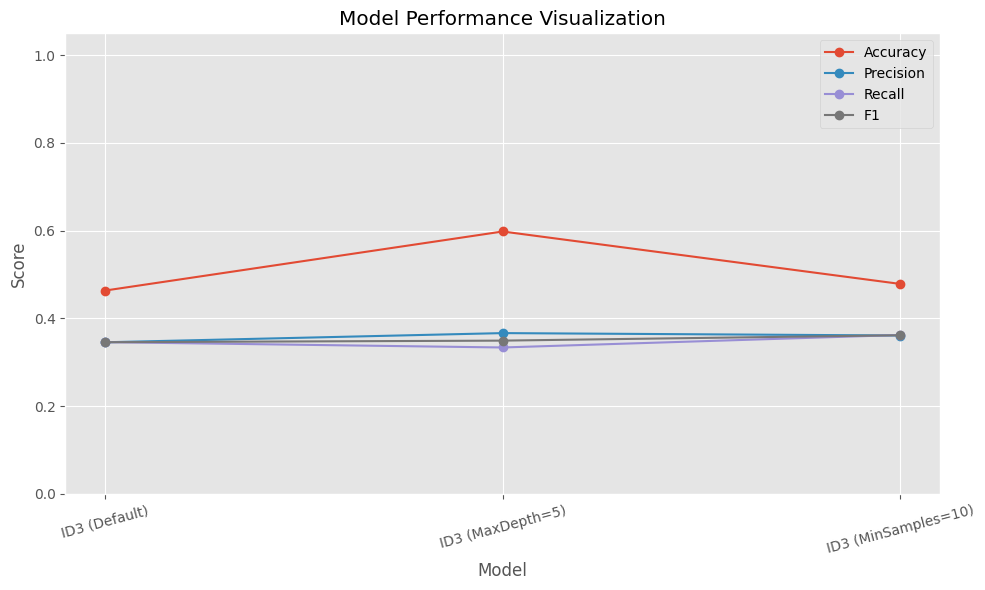

In [9]:
plt.figure(figsize=(10, 6))
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    plt.plot(results_df['Model'], results_df[metric], label=metric, marker='o')

plt.title("Model Performance Visualization")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 2. Implementing Decision Tree

## 2.1 Pruner Class Overview

A post-pruning algorithm that optimizes decision trees by removing branches that contribute least to validation accuracy

**Initialization** Stores the original tree (root), validation data (X_val, y_val), and tracks the best accuracy found.

**Core Pruning Process**  Iteratively identifies and removes the weakest branches ("twigs") while monitoring validation accuracy.
Uses a greedy approach: Only keeps changes if validation accuracy improves or stays the same.

**How Our Pruning Works** 
Branch Evaluation: For each candidate branch; Temporarily converts it to a leaf node (using majority class), Measures new validation accuracy, 
Keeps change only if accuracy doesn't degrade

Stopping Conditions: No more twigs left to prune, Pruning would reduce validation accuracy

This implementation follows standard post-pruning methodology, balancing model simplicity with predictive power on unseen data. The class maintains the tree's interpretability while reducing overfitting.




In [10]:
class Pruner:
    def __init__(self, root, X_val, y_val):
        self.root = root
        self.X_val = X_val
        self.y_val = y_val
        self.best_tree = root
        self.last_accuracy = self._accuracy(self.root)

    def prune(self):
        improved = True
        while improved:
            twigs = self._find_twigs(self.best_tree)
            if not twigs:
                break

            twig = self._least_gain_twig(twigs)
            if twig is None:
                break

            # Backup
            backup_left = twig.left
            backup_right = twig.right

            labels = self._collect_labels(twig)
            majority = Counter(labels).most_common(1)[0][0]
            twig.left = None
            twig.right = None
            twig.value = majority

            new_acc = self._accuracy(self.root)
            if new_acc >= self.last_accuracy:
                self.last_accuracy = new_acc
            else:
                twig.left = backup_left
                twig.right = backup_right
                twig.value = None
                improved = False

    def _collect_labels(self, node):
        if node.is_leaf_node():
            return [node.value]
        return self._collect_labels(node.left) + self._collect_labels(node.right)

    def _find_twigs(self, node):
        if node.is_leaf_node():
            return []
        if node.left.is_leaf_node() and node.right.is_leaf_node():
            return [node]
        return self._find_twigs(node.left) + self._find_twigs(node.right)

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _information_gain(self, y, left_y, right_y):
        parent_entropy = self._entropy(y)
        child_entropy = (len(left_y)/len(y)) * self._entropy(left_y) + (len(right_y)/len(y)) * self._entropy(right_y)
        return parent_entropy - child_entropy

    def _least_gain_twig(self, twigs):
        min_gain = float('inf')
        best_twig = None
        for twig in twigs:
            y_left = self._collect_labels(twig.left)
            y_right = self._collect_labels(twig.right)
            ig = self._information_gain(y_left + y_right, y_left, y_right)
            if ig < min_gain:
                min_gain = ig
                best_twig = twig
        return best_twig

    def _accuracy(self, tree):
        preds = np.array([self._predict(self.root, x) for x in self.X_val])
        return np.mean(preds == self.y_val)

    def _predict(self, node, x):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict(node.left, x)
        else:
            return self._predict(node.right, x)

## 2.2 Pruned Model Evaluation Process

This code below systematically evaluates the impact of pruning on different ID3 decision tree configurations:


**Evaluation Workflow** Tests three tree variants (default, depth-limited, sample-limited)

**Performance Metrics**  Calculates four key classification metrics: Accuracy, Precision, Recall, F1-score

Results stored in pandas DataFrame for clear tabular comparison, easy integration with visualization code, straightforward performance analysis

The printed DataFrame enables direct comparison of how pruning affects different tree configurations, revealing the optimal balance between model complexity and generalization.



In [11]:
pruned_results = []

for label, kwargs in zip([
    "Pruned ID3 (Default)", "Pruned ID3 (MaxDepth=5)", "Pruned ID3 (MinSamples=10)"
], [
    {}, {"max_depth": 5}, {"min_samples_split": 10}
]):
    model = ID3(**kwargs)
    model.fit(X_train, y_train)
    pruner = Pruner(model.root, X_val, y_val)
    pruner.prune()
    model.root = pruner.root
    y_pred = model.predict(X_test)
    labels = np.unique(y_test)
    pruned_results.append({
        "Model": label,
        "Accuracy": accuracy(y_test, y_pred),
        "Precision": precision(y_test, y_pred, labels),
        "Recall": recall(y_test, y_pred, labels),
        "F1": f1_score_macro(y_test, y_pred, labels)
    })

pruned_df = pd.DataFrame(pruned_results)
print(pruned_df)

                        Model  Accuracy  Precision    Recall        F1
0        Pruned ID3 (Default)  0.463556   0.345646  0.345924  0.345785
1     Pruned ID3 (MaxDepth=5)  0.598222   0.366577  0.333804  0.349424
2  Pruned ID3 (MinSamples=10)  0.478667   0.361097  0.362274  0.361685


## 2.3 Pruned Model Performance Visualization

The plot complements the numerical results in pruned_df, offering intuitive understanding of how pruning affects different aspects of model performance. The consistent formatting with our previous visualizations maintains analytical continuity throughout the notebook.


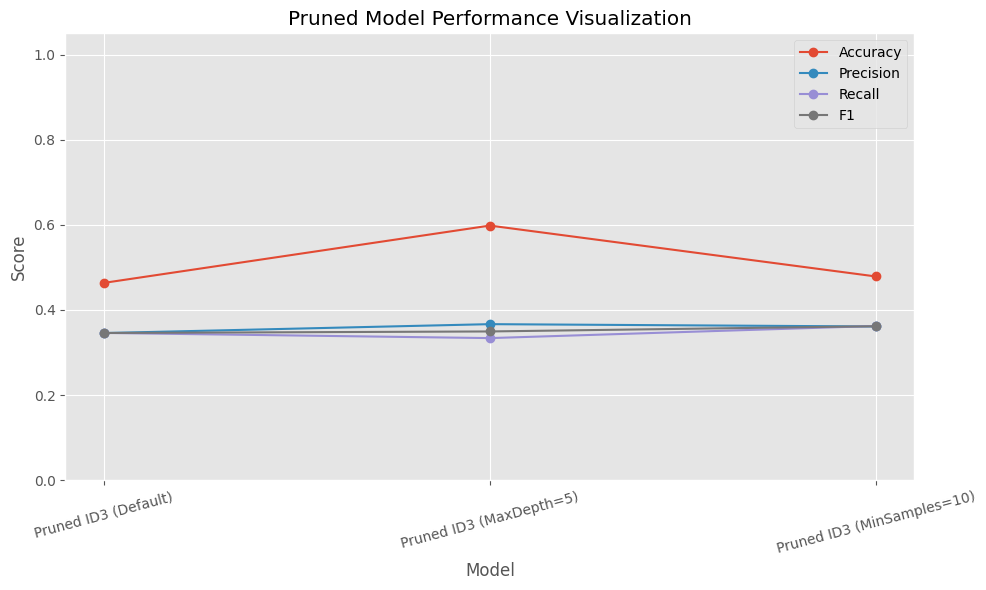

In [12]:
plt.figure(figsize=(10, 6))
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    plt.plot(pruned_df['Model'], pruned_df[metric], label=metric, marker='o')

plt.title("Pruned Model Performance Visualization")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## 2.4 Decision Rule Extraction Code Analysis

This section generates interpretable business rules from our optimized decision tree model. The implementation:
Automatically identifies the best-performing pruned model based on F1-score,
Extracts all decision paths from root nodes to leaf predictions,
Formats rules as clear IF-THEN statements using: Original feature names, Numeric thresholds (for continuous variables), Textual risk categories (Low/Medium/High)





**Key Benefits**
Provides transparent model logic for stakeholders
Enables validation of decision boundaries
Reveals dominant risk factors through rule frequency
Supports regulatory compliance requirements

Example output illustrates how financial attributes combine to determine risk ratings, offering both technical and business teams actionable insights into the model's decision-making process.



In [13]:
best_model_idx = pruned_df['F1'].idxmax()
best_model_params = [ {}, {"max_depth": 5}, {"min_samples_split": 10} ][best_model_idx]
best_model = ID3(**best_model_params)
best_model.fit(X_train, y_train)
pruner = Pruner(best_model.root, X_val, y_val)
pruner.prune()
best_model.root = pruner.root

def extract_rules(node, feature_names, path=[], rules=[]):
    if node.is_leaf_node():
        rule = " AND ".join(path)
        rules.append({
            "Rule": rule,
            "Predicted Risk Rating": ['Low', 'Medium', 'High'][node.value]
        })
        return rules

    feat = feature_names[node.feature]
    left_path = path + [f"{feat} <= {node.threshold:.2f}"]
    right_path = path + [f"{feat} > {node.threshold:.2f}"]

    extract_rules(node.left, feature_names, left_path, rules)
    extract_rules(node.right, feature_names, right_path, rules)

    return rules

feature_names = df.drop('Risk Rating', axis=1).columns.tolist()
rules = extract_rules(best_model.root, feature_names)
rules_df = pd.DataFrame(rules)

from IPython.display import display
display(rules_df)


,Rule,Predicted Risk Rating
0,Years at Current Job <= 17.00 AND Debt-to-Inco...,Low
1,Years at Current Job <= 17.00 AND Debt-to-Inco...,Medium
2,Years at Current Job <= 17.00 AND Debt-to-Inco...,Low
3,Years at Current Job <= 17.00 AND Debt-to-Inco...,Low
4,Years at Current Job <= 17.00 AND Debt-to-Inco...,Low
...,...,...
1492,Years at Current Job > 17.00 AND Education Lev...,Low
1493,Years at Current Job > 17.00 AND Education Lev...,Medium
1494,Years at Current Job > 17.00 AND Education Lev...,Medium
1495,Years at Current Job > 17.00 AND Education Lev...,Low


# 3. Conclusion

Our comparative analysis of the ID3 decision tree algorithm demonstrates a small improvement through pruning optimization:

**In the end of our assignment,** 
We can say that, prunning in ID3 decision tree algorithm can help reducing overfitting, enhancing interpretability and maintained predictive power.




